<a href="https://colab.research.google.com/github/kislay960/HackElite/blob/main/Hackelite%20%20Healthcare%20%20Claims.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##DATA LOADING


In [ ]:
#Importing all the required libraries and packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
import warnings
import pickle

In [ ]:
#Loading our dataset
fraud_tr = pd.read_csv('https://raw.githubusercontent.com/kislay960/HackElite/main/Train-1542865627584.csv')
bene_tr = pd.read_csv('https://raw.githubusercontent.com/kislay960/HackElite/main/Train_Beneficiarydata-1542865627584.csv')
inpatient_tr = pd.read_csv('https://raw.githubusercontent.com/kislay960/HackElite/main/Train_Inpatientdata-1542865627584.csv')
outpatient_tr = pd.read_csv('https://media.githubusercontent.com/media/kislay960/data/master/Train_Outpatientdata-1542865627584.csv')

##DATA VISUALIZATION

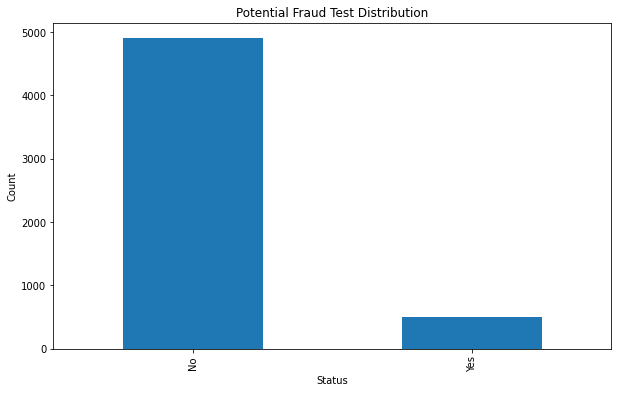

In [ ]:
#Visualizing number of potential frauds
plt.title('Potential Fraud Test Distribution')
fraud_tr.groupby( ["PotentialFraud"] ).Provider.count().plot(kind = "bar", figsize = (10,6))
plt.xlabel('Status')
plt.ylabel('Count')
plt.show()

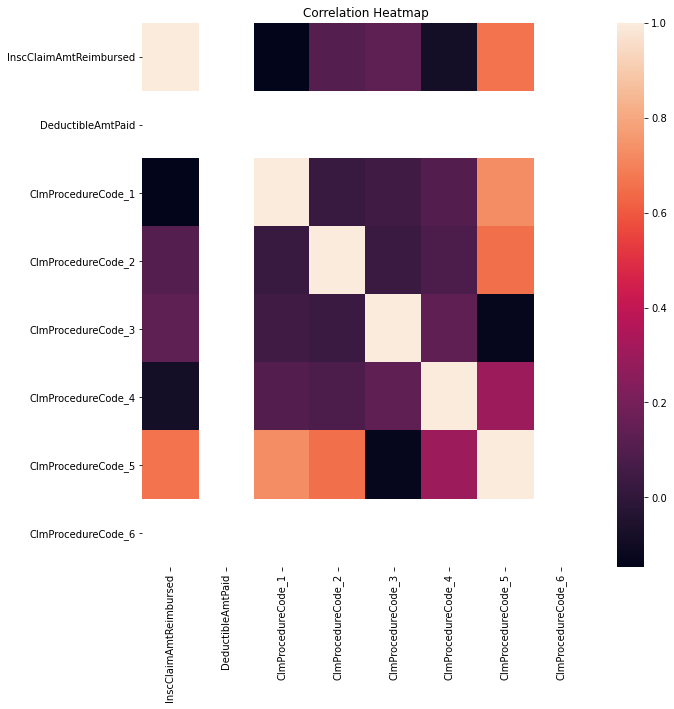

In [ ]:
#Correlation heatmap for better understanding of the dataset
plt.figure(figsize=(10,10))
plt.title('Correlation Heatmap')
sns.heatmap(inpatient_tr.corr())
plt.show()

##FINDING DISCREPANCIES IN DATA

In [ ]:
flag = True

df = pd.DataFrame()
df = bene_tr[bene_tr['Gender']>2]
df = bene_tr[bene_tr['Gender']<1]

if df.shape[0] != 0:
    print("Please correct the discrepancies in the 'Gender' column")
    flag = False

df = pd.DataFrame()
df = bene_tr[bene_tr['State']>54]
df = bene_tr[bene_tr['State']<1]

if df.shape[0] != 0:
    print("Please correct the discrepancies in the 'State' column")
    flag = False

df = pd.DataFrame()
df = bene_tr[bene_tr['County']>999]
df = bene_tr[bene_tr['County']<0]

if df.shape[0] != 0:
    print("Please correct the discrepancies in the 'County' column")
    flag = False

df = pd.DataFrame()
df = inpatient_tr[inpatient_tr['ClaimID'].duplicated()]

if df.shape[0] != 0:
    print("Multiple people have entered same ClaimID. ")
    flag = False

In [ ]:
if flag:
    print("No discrepancies Found!")

No discrepancies Found!


##OVERPAYMENT RECOVERY

In [ ]:
#overpayment table
overpmnt = pd.DataFrame([bene_tr.BeneID, bene_tr.IPAnnualReimbursementAmt, bene_tr.IPAnnualDeductibleAmt, bene_tr.OPAnnualReimbursementAmt, bene_tr.OPAnnualDeductibleAmt]).transpose()

In [ ]:
overpmnt.head()

,BeneID,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,36000,3204,60,70
1,BENE11002,0,0,30,50
2,BENE11003,0,0,90,40
3,BENE11004,0,0,1810,760
4,BENE11005,0,0,1790,1200


In [ ]:
overpmnt['Bill'] = overpmnt['IPAnnualReimbursementAmt'] + overpmnt['OPAnnualReimbursementAmt']
overpmnt['Reimbursement'] = overpmnt['IPAnnualDeductibleAmt'] + overpmnt['OPAnnualDeductibleAmt']

In [ ]:
overpmnt.head()

,BeneID,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Bill,Reimbursement
0,BENE11001,36000,3204,60,70,36060,3274
1,BENE11002,0,0,30,50,30,50
2,BENE11003,0,0,90,40,90,40
3,BENE11004,0,0,1810,760,1810,760
4,BENE11005,0,0,1790,1200,1790,1200


In [ ]:
overpmnt.drop(overpmnt.columns[[1,2,3,4]], axis=1, inplace=True)
overpmnt.head()

,BeneID,Bill,Reimbursement
0,BENE11001,36060,3274
1,BENE11002,30,50
2,BENE11003,90,40
3,BENE11004,1810,760
4,BENE11005,1790,1200


In [ ]:
overpmnt['Overpayment'] = np.where(overpmnt['Bill']>overpmnt['Reimbursement'],True,False)

In [57]:
overpmnt['Underpayment'] = np.where(overpmnt['Bill']<overpmnt['Reimbursement'],True,False)

In [58]:
overpmnt.head()

,BeneID,Bill,Reimbursement,Overpayment,Underpayment
0,BENE11001,36060,3274,True,False
1,BENE11002,30,50,False,True
2,BENE11003,90,40,True,False
3,BENE11004,1810,760,True,False
4,BENE11005,1790,1200,True,False


##DATA CLEANING AND DATA PREPARATION

In [64]:
In_Provider=pd.DataFrame([inpatient_tr['Provider'].value_counts().index,inpatient_tr['Provider'].value_counts()]).transpose().rename({0:'Provider',1:'Inpatient_Claim_Number'},axis=1)
Out_Provider=pd.DataFrame([outpatient_tr['Provider'].value_counts().index,outpatient_tr['Provider'].value_counts()]).transpose().rename({0:'Provider',1:'Outpatient_Claim_Number'},axis=1)

In [79]:
In_Provider.head()

,Provider,Inpatient_Claim_Number
0,PRV52019,516
1,PRV55462,386
2,PRV54367,322
3,PRV53706,282
4,PRV55209,275


In [80]:
Out_Provider.head()

,Provider,Outpatient_Claim_Number
0,PRV51459,8240
1,PRV53797,4739
2,PRV51574,4444
3,PRV53918,3588
4,PRV54895,3433


In [67]:
provider_claimnumber=pd.merge(In_Provider,Out_Provider,on='Provider',how='outer')

In [68]:
provider_claimnumber.head()

,Provider,Inpatient_Claim_Number,Outpatient_Claim_Number
0,PRV52019,516,1445
1,PRV55462,386,1521
2,PRV54367,322,314
3,PRV53706,282,191
4,PRV55209,275,487


In [69]:
inreimburse_by_provider=inpatient_tr.groupby('Provider')['InscClaimAmtReimbursed'].sum()
inreimburse_temp1=pd.DataFrame([inreimburse_by_provider.index,inreimburse_by_provider])
inreimburse_temp2=inreimburse_temp1.transpose()

In [70]:
inreimburse_temp2.head()

,0,1
0,PRV51001,97000
1,PRV51003,573000
2,PRV51007,19000
3,PRV51008,25000
4,PRV51011,5000


In [71]:
In_Provider_Claim=inreimburse_temp2.rename({0:'Provider',1:'Inpatient_Claim_Amount'},axis=1)

In [72]:
In_Provider_Claim.head()

,Provider,Inpatient_Claim_Amount
0,PRV51001,97000
1,PRV51003,573000
2,PRV51007,19000
3,PRV51008,25000
4,PRV51011,5000


In [73]:
outreimburse_by_provider=outpatient_tr.groupby('Provider')['InscClaimAmtReimbursed'].sum()
outreimburse_temp=pd.DataFrame([outreimburse_by_provider.index,outreimburse_by_provider]).transpose()

In [74]:
outreimburse_temp.head()

,0,1
0,PRV51001,7640
1,PRV51003,32670
2,PRV51004,52170
3,PRV51005,280910
4,PRV51007,14710


In [75]:
Out_Provider_Claim=outreimburse_temp.rename({0:'Provider',1:'Outpatient_Claim_Amount'},axis=1)
provider_claimamount=pd.merge(In_Provider_Claim,Out_Provider_Claim,on='Provider',how='outer')

In [76]:
provider_claimamount.head()

,Provider,Inpatient_Claim_Amount,Outpatient_Claim_Amount
0,PRV51001,97000,7640
1,PRV51003,573000,32670
2,PRV51007,19000,14710
3,PRV51008,25000,10630
4,PRV51011,5000,11630


In [77]:
provider_list1=pd.merge(fraud_tr,provider_claimnumber,on='Provider',how='outer')
provider_list2=pd.merge(provider_list1,provider_claimamount,on='Provider',how='outer')

In [78]:
provider_list2.head()

,Provider,PotentialFraud,Inpatient_Claim_Number,Outpatient_Claim_Number,Inpatient_Claim_Amount,Outpatient_Claim_Amount
0,PRV51001,No,5,20,97000,7640
1,PRV51003,Yes,62,70,573000,32670
2,PRV51004,No,NaN,149,NaN,52170
3,PRV51005,Yes,NaN,1165,NaN,280910
4,PRV51007,No,3,69,19000,14710


In [ ]:
#Filling NAN Values with zero
provider_clean=provider_list2.fillna(0)

##FRAUD DETECTION

In [ ]:
#separating input nd output for fraud detection
y = provider_clean['PotentialFraud'].values
X = provider_clean.drop(['PotentialFraud','Provider'], axis=1).values

In [ ]:
warnings. filterwarnings('ignore')

In [ ]:
#KNN Model
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3, random_state=21, stratify=y)
param_grid = {'n_neighbors': np.arange(1, 15)}
knn = KNeighborsClassifier()
knn_cv1 = GridSearchCV(knn, param_grid, cv=5)
knn_cv1.fit(X_train1, y_train1)
print('Accuracy : {}%'.format(knn_cv1.best_score_*100))

Accuracy : 93.13429974590714%


In [ ]:
print(y_train1)

['No' 'Yes' 'No' ... 'Yes' 'No' 'No']


In [ ]:
filename = open('knn_cv1.pkl','wb')
pickle.dump(knn_cv1,filename)
#Download this pickle file.

##PAYMENT MODE PREFERENCE

In [ ]:
provider_clean.head()

,Provider,PotentialFraud,Inpatient_Claim_Number,Outpatient_Claim_Number,Inpatient_Claim_Amount,Outpatient_Claim_Amount
0,PRV51001,No,5,20,97000,7640
1,PRV51003,Yes,62,70,573000,32670
2,PRV51004,No,0,149,0,52170
3,PRV51005,Yes,0,1165,0,280910
4,PRV51007,No,3,69,19000,14710


In [ ]:
provider_clean['Mode_of_Payment'] = np.where(provider_clean['Inpatient_Claim_Number']<3,'Check','EFT')

In [ ]:
y = provider_clean['Mode_of_Payment'].values
X = provider_clean.drop(['PotentialFraud','Provider','Mode_of_Payment'], axis=1).values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21, stratify=y)
param_grid = {'n_neighbors': np.arange(1, 15)}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv=5)
knn_cv.fit(X_train, y_train)
print('Accuracy : {}%'.format(knn_cv.best_score_*100))

Accuracy : 96.83112410814806%


In [ ]:
#Checking on sample input
knn_cv.predict([[5,20,97000,7640]])

array(['EFT'], dtype=object)

In [ ]:
#Save and download the model
finalfile = open('knn_cv.pkl','wb')
pickle.dump(knn_cv, finalfile)